<a href="https://colab.research.google.com/github/costadev00/AI-algorithms-from-scratch/blob/main/GPT_FROM_SCRATCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Welcome to GPT Learning Hub !

# I created this companion notebook to help anyone learning from the coding problems see their working GPT in action.

# I use this notebook to help me fixes my ML learning. If you want to talk, contact me at linkedin: https://www.linkedin.com/in/costadeveloper/

Before running anything, Runtime -> Change Runtime Type -> T4 GPU. This will speed up the results. Just run each cell one by one to generate the Drake lyrics, which uses your exact code from the problem!

In [6]:
import torch
import torch.nn as nn
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
if device.type == 'cuda':
    print("We have GPU and we are using: ",torch.cuda.get_device_name(0))
else:
    print('Using only CPU')

We have GPU and we are using:  Tesla T4


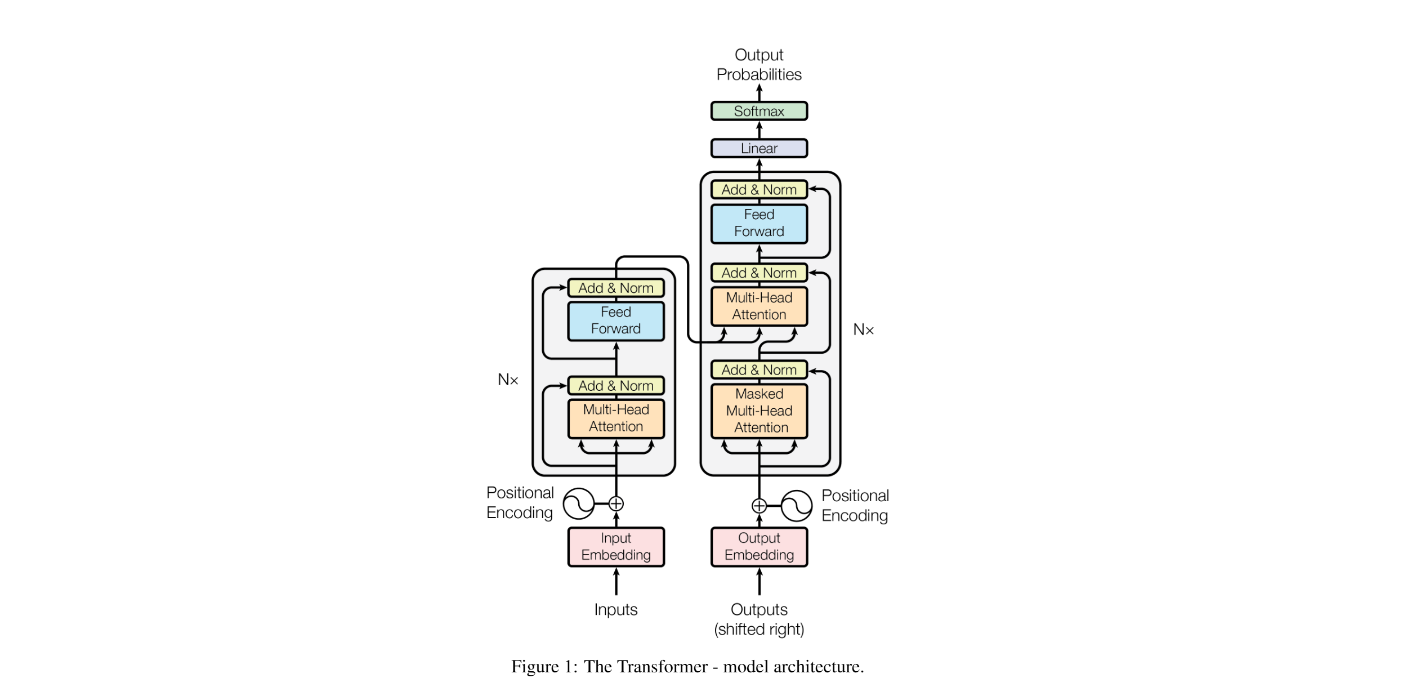This code defines a GPT(Generative Pre-Trained Transformer) model using Pytorch.

It's based on the transformer architecture and is designed for NLP tasks.

The GPT class, encapsulates the entire model:
1. Embedding layers for tokens and positions
2. Multiple TransformerBlocks for processing the input sequence.
3. A final layer for projecting the output to a vocabulary space

Each TransformerBlock contains:
1. MultiHeadedSelfAttention for capturing the relationship between tokens.
2. A VanillaNeuralNetwork(feed foward network) for further processing.
3. Layer normalization for stabilizing training

The model uses skips connections and dropout functions for improved performance
It is designed to handle sequential data

In [7]:
class GPT(nn.Module):

    class TransformerBlock(nn.Module):

        class MultiHeadedSelfAttention(nn.Module):

            class SingleHeadAttention(nn.Module):
                def __init__(self, model_dim: int, head_size: int):
                    super().__init__()
                    self.key_layer = nn.Linear(model_dim, head_size, bias=False)
                    self.query_layer = nn.Linear(model_dim, head_size, bias=False)
                    self.value_layer = nn.Linear(model_dim, head_size, bias=False)

                def forward(self, embedded):
                    k = self.key_layer(embedded)
                    q = self.query_layer(embedded)
                    v = self.value_layer(embedded)

                    scores = q @ torch.transpose(k, 1, 2) # @ is the same as torch.matmul()
                    context_length, attention_dim = k.shape[1], k.shape[2]
                    scores = scores / (attention_dim ** 0.5)

                    lower_triangular = torch.tril(torch.ones(context_length, context_length))
                    mask = (lower_triangular == 0).to(device)
                    scores = scores.masked_fill(mask, float('-inf'))
                    scores = nn.functional.softmax(scores, dim = 2)

                    return scores @ v

            def __init__(self, model_dim: int, num_heads: int):
                super().__init__()
                self.attention_heads = nn.ModuleList()
                for i in range(num_heads):
                    self.attention_heads.append(self.SingleHeadAttention(model_dim, model_dim // num_heads))
                self.compute = nn.Linear(model_dim, model_dim)
                self.dropout = nn.Dropout(0.2)

            def forward(self, embedded):
                head_outputs = []
                for head in self.attention_heads:
                    head_outputs.append(head(embedded))
                concatenated = torch.cat(head_outputs, dim = 2)
                return self.dropout(self.compute(concatenated))

        class VanillaNeuralNetwork(nn.Module):

            def __init__(self, model_dim: int):
                super().__init__()
                self.first_linear_layer = nn.Linear(model_dim, model_dim * 4)
                self.relu = nn.ReLU()
                self.second_linear_layer = nn.Linear(model_dim * 4, model_dim)
                self.dropout = nn.Dropout(0.2) # using p = 0.2

            def forward(self, x):
                return self.dropout(self.second_linear_layer(self.relu(self.first_linear_layer(x))))

        def __init__(self, model_dim: int, num_heads: int):
            super().__init__()
            self.mhsa = self.MultiHeadedSelfAttention(model_dim, num_heads)
            self.vanilla_nn = self.VanillaNeuralNetwork(model_dim)
            self.layer_norm_one = nn.LayerNorm(model_dim)
            self.layer_norm_two = nn.LayerNorm(model_dim)

        def forward(self, embedded):
            embedded = embedded + self.mhsa(self.layer_norm_one(embedded)) # skip connection
            embedded = embedded + self.vanilla_nn(self.layer_norm_two(embedded)) # another skip connection
            return embedded

    def __init__(self, vocab_size: int, context_length: int, model_dim: int, num_blocks: int, num_heads: int):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, model_dim)
        self.pos_embedding = nn.Embedding(context_length, model_dim)
        self.transformer_blocks = nn.Sequential()
        for i in range(num_blocks):
            self.transformer_blocks.append(self.TransformerBlock(model_dim, num_heads))
        self.layer_norm_three = nn.LayerNorm(model_dim)
        self.vocab_projection = nn.Linear(model_dim, vocab_size)

    def forward(self, context):
        embedded = self.token_embedding(context)
        context_length = context.shape[1]
        positions = torch.arange(context_length).to(device)
        embedded = embedded + self.pos_embedding(positions)

        raw_output = self.vocab_projection(self.layer_norm_three(self.transformer_blocks(embedded)))
        # raw_output is batch by context_length by vocab_size

        return raw_output

This function is the core of the text generation process. It takes a trained GPT model and uses it to generate new text, character by character.

###Function Arguments:


*   **model:** The trained GPT model that will be used for generating text
*   **new_chars:** The number of new characters to generate.
*   **context:** The initial text sequence used as a starting point for generation. It is a Pytorch tensor in our case
*   **context_length:** The maximum length of the context sequence to consider
*   **int_to_char:**  A dictionary that maps int representation of chars to their actual char values.

###Main components:

The text generation has 3 main components that is important to notice:
B = The size of each batch that the model can process
T = The number of tokens in the input at that timestep
V = The probabilities, of the vocabulary at that timestep

**The input is going to be a tensor of BxT and the Output is going to be a BxTxV, and in every iteration we append V to T and rerun the generation of the token probabilities.**




In [8]:
def generate(model, new_chars: int, context, context_length: int, int_to_char: dict) -> str:
    res = []
    for i in range(new_chars):
        if len(context.T) > context_length:
            context = context[:, -context_length:]
        prediction = model(context) # B, T, Vocab_Size
        last_time_step = prediction[:, -1, :] # B, Vocab_Size
        probabilities = nn.functional.softmax(last_time_step, dim = -1)
        next_char = torch.multinomial(probabilities, 1)
        context = torch.cat((context, next_char), dim = -1)
        res.append(int_to_char[next_char.item()])
    return ''.join(res)

Let's download the pre-trained model:


In sumarry this is a neural network pre-trained with some pattern of the text that has been inputed to it.

**Basically it is the weights that we are going to use to feed our model, and generates new samples of text, using the Transformer Architecture.**

In [9]:
!git clone https://github.com/gptandchill/drake-lyric-generator
%cd drake-lyric-generator

Cloning into 'drake-lyric-generator'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), 16.53 MiB | 15.97 MiB/s, done.
/content/drake-lyric-generator


Define the hyperparameters, instantiate the model, and load in the weights from training. The prior cell downloads weights.pt into this Colab runtime.

In [15]:
vocab_size = 104
context_length = 128
model_dim = 252
num_blocks = 6
num_heads = 6

model = GPT(vocab_size, context_length, model_dim, num_blocks, num_heads).to(device)
WEIGHT_PATH = 'weights.pt' # Adjust as necessary
model.load_state_dict(torch.load(WEIGHT_PATH))
model.eval()
new_chars = 5000
context = torch.zeros(1, 1, dtype = torch.int64).to(device)

int_to_char = {0: '\n', 1: ' ', 2: '!', 3: '"', 4: '$', 5: '%', 6: '&', 7: "'", 8: '(', 9: ')', 10: '*', 11: '+', 12: ',', 13: '-', 14: '.', 15: '/', 16: '0', 17: '1', 18: '2', 19: '3', 20: '4', 21: '5', 22: '6', 23: '7', 24: '8', 25: '9', 26: ':', 27: ';', 28: '?', 29: 'A', 30: 'B', 31: 'C', 32: 'D', 33: 'E', 34: 'F', 35: 'G', 36: 'H', 37: 'I', 38: 'J', 39: 'K', 40: 'L', 41: 'M', 42: 'N', 43: 'O', 44: 'P', 45: 'Q', 46: 'R', 47: 'S', 48: 'T', 49: 'U', 50: 'V', 51: 'W', 52: 'X', 53: 'Y', 54: 'Z', 55: '[', 56: ']', 57: '_', 58: 'a', 59: 'b', 60: 'c', 61: 'd', 62: 'e', 63: 'f', 64: 'g', 65: 'h', 66: 'i', 67: 'j', 68: 'k', 69: 'l', 70: 'm', 71: 'n', 72: 'o', 73: 'p', 74: 'q', 75: 'r', 76: 's', 77: 't', 78: 'u', 79: 'v', 80: 'w', 81: 'x', 82: 'y', 83: 'z', 84: '{', 85: '|', 86: '}', 87: 'à', 88: 'á', 89: 'è', 90: 'é', 91: 'ë', 92: 'ñ', 93: 'ó', 94: 'ú', 95: '\u2005', 96: '–', 97: '—', 98: '‘', 99: '’', 100: '“', 101: '”', 102: '…', 103: '\u205f'}

Run the below cell over and over again to get new lyrics!

In [11]:
print(generate(model, new_chars,context,
               context_length,
               int_to_char))

Started it get special are up in the off that my down, gama we could get me into
Play new her again, I get a one Weekel

[Intro]
Ayy
Hook, ayy
Ayy, ayy, ayy, ayy, ayy, ayy, ayy
T-Wayy
AmG, best (Ayy), How (AXLea—40, and (Ayy)
AXL)

[Hook]
No Yow yeah, yeah, ayeah
I want in (Ayy), and I am (Ayy, ayy, too!)
(PAXVO—)
(Ayy, yeah, ayy, ayy, ayy, ayy, ayy)
I gotta fanst it, that's why you're doin' up, you still pip out a hudre to still around
Niggas nice got me with I was home the love in you
What you are dudin' the park at that is easy heart
Clipips-clearted, yeah

[Chorus: Drake]
Yeah, I know yeah
It's eaty, I know I know, I'm hide
I make you, never can't let this soul so I know
I'm here bad! (Yeah, what’s be)
I bring that's up 'cause you can't hain stear pullecter
I just be strivin', tryna sing that I ain't never know
What do with shere anything, why you're worrything for ence rictin'
But no eato, no, no, we started to get at them crown
Now I'll the new love, ayy, ayy
Sayy, yeah, that lik